### Mark Lisi (ml2622)
# Malaria Detection Using Convolutional Neural Networks

Machine learning is a central tool in the field of bioinformatics with a wide range of applications;  by training a convolutional neural network (CNN) on images of cells - both infected with malaria and uninfected - we can accurately detect the presence of malaria using just an image.

## 0. Formulating the Problem

Malaria is one of the oldest and deadliest known diseases on Earth. Even in the 2020s, there are hundreds of millions of malaria cases every year, most of them in Africa ([WHO](https://www.who.int/news-room/fact-sheets/detail/malaria)).

Until recently, preventative measures for malaria were very limited - mosquito nets are helpful, but can only do so much in arid climates like those in central Africa. In 2021 a breakthrough vaccine was developed that significantly reduces the deadliness of malaria - particularly in young children - even when used in areas that already have access to insecticide-treated nets and treatment/diagnosis are readily available.

In the words of the WHO, this vaccination can ["reinvigorate the fight against malaria"](https://www.who.int/news/item/06-10-2021-who-recommends-groundbreaking-malaria-vaccine-for-children-at-risk). For this reason, diagnosis and treatment are as important as ever. We can build a convolutional neural network to act as a malaria diagnoser - with cell images as input, the CNN will be able to determine whether malaria is present in the cell with (hopefully) high accuracy. 

## 1. Data Loading/Parsing

In [3]:
# For our CNN
import tensorflow as tf 
import numpy as np 
from tensorflow.keras import datasets, layers, models

# For file/image parsing
import cv2 
from PIL import Image
import os
import matplotlib.pyplot as plt

First, we must load our data! We are using the following cell image dataset from Kaggle: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria

Since this dataset separates infected and uninfected images, we can add binary labels as we load the images (0 for uninfected, 1 for infected). We will also employ a trick to get the most out of our image data; we will add some distorted copies of our images to the dataset. As well as effectively increasing the size of our dataset, this addition will give our model experience with imperfect images, and will ultimately strengthen it. 

In [4]:
infected = os.listdir('data/cell_images/cell_images/Parasitized/') 
uninfected = os.listdir('data/cell_images/cell_images/Uninfected/')


data = []
labels = []

for i in infected:
    try:
        image = cv2.imread("data/cell_images/cell_images/Parasitized/"+i)
        image_array = Image.fromarray(image , 'RGB')    
        resize_img = image_array.resize((50 , 50)) # Make sure our images are of uniform size
        # Applying some distortions to our training data will make our model more robust!
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        blur = cv2.blur(np.array(resize_img) ,(10,10))
        data.append(np.array(resize_img))
        data.append(np.array(rotated45))
        data.append(np.array(rotated75))
        data.append(np.array(blur))
        labels.extend([1,1,1,1])
        
    except AttributeError: # If CV2 can't read in the image, we discard it.
        pass
    
for u in uninfected:
    try:
        image = cv2.imread("data/cell_images/cell_images/Uninfected/"+u)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50)) # More resizing...
        # ...and more distortions.
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        blur = cv2.blur(np.array(resize_img) ,(10,10))
        data.append(np.array(resize_img))
        data.append(np.array(rotated45))
        data.append(np.array(rotated75))
        data.append(np.array(blur))
        labels.extend([0,0,0,0])
        
    except AttributeError:
        pass

In [5]:
cells = np.array(data)
labels = np.array(labels)

Let's take a look at some of our data:

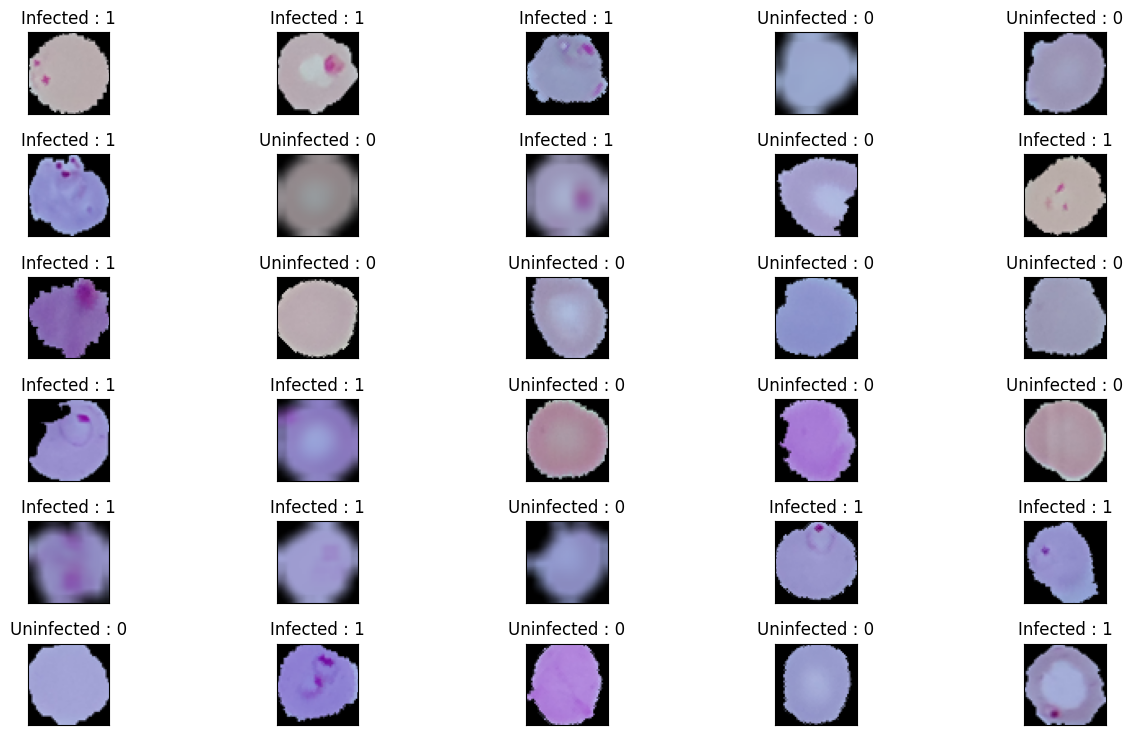

In [6]:
plt.figure(1 , figsize = (15 , 9))
for i in range(1, 31):
    r = np.random.randint(0 , cells.shape[0] , 1)
    plt.subplot(6 , 5 , i)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(cells[r[0]])
    plt.title('{} : {}'.format('Infected' if labels[r[0]] == 1 else 'Uninfected' , labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])
plt.show()



We can observe the distortions that we applied in this random snapshot of the training data - it's difficult to discern which ones have been rotated, but we can clearly see the blurring effect in a few of these examples.

Lastly, we will shuffle together the infected and uninfected images and split the data into test and training data.

In [7]:
n = np.arange(len(cells)) # n is a list of ordered indices: (0, 1, 2, ... , len(cells))
np.random.shuffle(n) # then we shuffle it!

# numpy syntax to neatly reorder a list in-place
cells = cells[n]
labels = labels[n]

In [8]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(cells, labels, test_size=0.2)

## 2. Constructing the Model

Now that our data is properly loaded in, we can begin the actual classification process! Binary classification problems such as these can be approached in many ways - for image classification, convolutional neural networks are a reliably accurate option.

In essence, convolutional neural networks operate by taking a set of kernels and "sweeping over" the input - the kernels themselves are tensors with entries that are trained weights. The resulting output is a "feature map"

We can start with a relatively simple CNN - 

In [15]:
model_a = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(50,50,3)),
        layers.Conv2D(32, kernel_size=(6, 6), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(3, 3), padding='same'),
        layers.Conv2D(32, kernel_size=(6, 6), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(3, 3), padding='same'),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid'),
    ]
)

model_a.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 50, 50, 32)        3488      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 17, 17, 32)        36896     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1152)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                

As indicated by the summary, our convolutional neural network has two convolutional layers with a pooling layer after each one, a flatten layer, and one dense neuron with a sigmoid activation function.



## 3. Training...

We can now compile and start training our model.  

In [16]:
batch_size = 128
epochs = 5

model_a.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_a.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
621/621 [==============================] - 59s 95ms/step - loss: 0.8312 - accuracy: 0.6719 - val_loss: 0.3709 - val_accuracy: 0.8442
Epoch 2/5
621/621 [==============================] - 57s 92ms/step - loss: 0.2649 - accuracy: 0.9016 - val_loss: 0.2247 - val_accuracy: 0.9235
Epoch 3/5
621/621 [==============================] - 59s 95ms/step - loss: 0.2081 - accuracy: 0.9284 - val_loss: 0.2137 - val_accuracy: 0.9250
Epoch 4/5
621/621 [==============================] - 60s 96ms/step - loss: 0.1892 - accuracy: 0.9351 - val_loss: 0.1900 - val_accuracy: 0.9322
Epoch 5/5
621/621 [==============================] - 58s 94ms/step - loss: 0.1844 - accuracy: 0.9367 - val_loss: 0.2118 - val_accuracy: 0.9237


With our CNN, we were able to achieve a training accuracy of ~93.7%!

## 4. ...and Testing!

In [18]:
score = model_a.evaluate(test_images, test_labels, verbose=0)
print("Test loss: %.4f" % score[0])
print("Test accuracy: %.2f%%" % (100*score[1]))

Test loss: 0.2094
Test accuracy: 92.39%


Our test accuracy is almost as high as our training accuracy - ~92.4% - which should dispel any worries of overfitting the model during training.

## 5. Variations

Next, we can vary some hyperparameters to see if we can improve our model's performance, starting by adjusting the kernel size of the convolutional layers. We'll try smaller sizes for one model..

In [19]:
model_b = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(50,50,3)),
        layers.Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(3, 3), padding='same'),
        layers.Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(3, 3), padding='same'),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid'),
    ]
)

model_b.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 50, 50, 32)        1568      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 17, 17, 32)        16416     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1152)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                

...and larger sizes for another!

In [20]:
model_c = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(50,50,3)),
        layers.Conv2D(32, kernel_size=(9, 9), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(3, 3), padding='same'),
        layers.Conv2D(32, kernel_size=(9, 9), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(3, 3), padding='same'),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid'),
    ]
)
model_c.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 50, 50, 32)        7808      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 17, 17, 32)        82976     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1152)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [21]:
batch_size = 128
epochs = 5

model_b.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_b.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.1)

model_c.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_c.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
621/621 [==============================] - 43s 69ms/step - loss: 0.8982 - accuracy: 0.6780 - val_loss: 0.5294 - val_accuracy: 0.7450
Epoch 2/5
621/621 [==============================] - 43s 69ms/step - loss: 0.4119 - accuracy: 0.8122 - val_loss: 0.2797 - val_accuracy: 0.8874
Epoch 3/5
621/621 [==============================] - 43s 70ms/step - loss: 0.2468 - accuracy: 0.9081 - val_loss: 0.2267 - val_accuracy: 0.9223
Epoch 4/5
621/621 [==============================] - 43s 69ms/step - loss: 0.2130 - accuracy: 0.9261 - val_loss: 0.2249 - val_accuracy: 0.9160
Epoch 5/5
621/621 [==============================] - 42s 68ms/step - loss: 0.1992 - accuracy: 0.9317 - val_loss: 0.2004 - val_accuracy: 0.9350
Epoch 1/5
621/621 [==============================] - 118s 189ms/step - loss: 1.0339 - accuracy: 0.6329 - val_loss: 0.6136 - val_accuracy: 0.6535
Epoch 2/5
621/621 [==============================] - 110s 177ms/step - loss: 0.5709 - accuracy: 0.7022 - val_loss: 0.5453 - val_accuracy: 0.

The kernel size seems to have minimal impact on training accuracy - we can confirm that the same is true of our test accuracies.

In [22]:
score = model_b.evaluate(test_images, test_labels, verbose=0)
print("Test loss: %.4f" % score[0])
print("Test accuracy: %.2f%%" % (100*score[1]))

Test loss: 0.1925
Test accuracy: 93.70%


In [23]:
score = model_c.evaluate(test_images, test_labels, verbose=0)
print("Test loss: %.4f" % score[0])
print("Test accuracy: %.2f%%" % (100*score[1]))

Test loss: 0.1963
Test accuracy: 92.43%


These results are quite illuminating in terms of how convolutional neural networks really work. The performance of a CNN at a classification task is not tied to kernel size - in other words, bigger isn't always better! In fact, the smallest kernel had the highest test accuracy of the three models. So then, how can we improve our model? Next, we can fix the convolutional layers and vary the pooling size.

In [24]:
model_d = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(50,50,3)),
        layers.Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(4, 4), padding='same'),
        layers.Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(4, 4), padding='same'),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid'),
    ]
)

model_d.summary()

model_e = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(50,50,3)),
        layers.Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
        layers.Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid'),
    ]
)

model_e.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 50, 50, 32)        1568      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 32)        16416     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 4, 4, 32)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [25]:
model_d.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_d.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.1)

model_e.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_e.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
621/621 [==============================] - 37s 59ms/step - loss: 0.9416 - accuracy: 0.7179 - val_loss: 0.4168 - val_accuracy: 0.8253
Epoch 2/5
621/621 [==============================] - 36s 58ms/step - loss: 0.3163 - accuracy: 0.8756 - val_loss: 0.3879 - val_accuracy: 0.8415
Epoch 3/5
621/621 [==============================] - 37s 60ms/step - loss: 0.2434 - accuracy: 0.9141 - val_loss: 0.2399 - val_accuracy: 0.9122
Epoch 4/5
621/621 [==============================] - 37s 59ms/step - loss: 0.2140 - accuracy: 0.9259 - val_loss: 0.2094 - val_accuracy: 0.9296
Epoch 5/5
621/621 [==============================] - 36s 58ms/step - loss: 0.1999 - accuracy: 0.9316 - val_loss: 0.2066 - val_accuracy: 0.9319
Epoch 1/5
621/621 [==============================] - 64s 102ms/step - loss: 0.9270 - accuracy: 0.6307 - val_loss: 0.6514 - val_accuracy: 0.6250
Epoch 2/5
621/621 [==============================] - 64s 103ms/step - loss: 0.5803 - accuracy: 0.6997 - val_loss: 0.5526 - val_accuracy: 0.72

In [27]:
score = model_d.evaluate(test_images, test_labels, verbose=0)
print("Test loss: %.4f" % score[0])
print("Test accuracy: %.2f%%" % (100*score[1]))

score = model_e.evaluate(test_images, test_labels, verbose=0)
print("Test loss: %.4f" % score[0])
print("Test accuracy: %.2f%%" % (100*score[1]))

Test loss: 0.2021
Test accuracy: 93.45%
Test loss: 0.2310
Test accuracy: 92.26%


Variation in the size of the pooling layer also has little effect on accuracy.

## 6. Conclusions

Our convolutional neural network was able to correctly identify the presence of malaria in a cell image with ~94% accuracy. Still, when we made variations in efforts to improve this accuracy, none seemed to have a great effect - why might this be? One of the fundamental principles of a CNN is the idea of kernel learning; the kernels in a CNN should not be fixed, but rather *learned* from the data. Because of this behavior, as long as the starting point of the kernel is within a semi-reasonable range, the accuracy will barely be affected by changing that initial kernel size. 